In [1]:
import time
import math

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy import interpolate

sns.set_theme()

# Simulation de loi normale

In [2]:
def box_muller(u):
    odd = False
    if len(u)%2!=0 :
        odd = True
        u = np.concatenate((u, np.random.uniform(size=(1))))

    gauss = np.zeros(len(u))
    longueur = len(u)//2
    for i in range(longueur):
        gauss[2*i] = np.sqrt(-2*np.log(u[i]))*np.cos(2*np.pi*u[2*longueur-i-1])
        gauss[2*i+1] = np.sqrt(-2*np.log(u[i]))*np.sin(2*np.pi*u[2*longueur-1-i])
    
    gauss = gauss[:-1] if odd else gauss
    return gauss

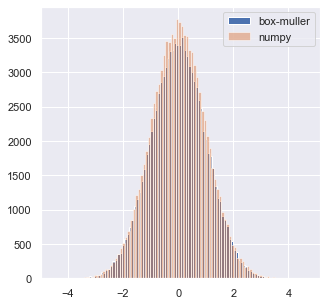

In [3]:
p = 100001
U = np.random.uniform(size=(p))
Z = box_muller(U)

assert len(Z) == p
plt.figure(figsize=(5, 5))
plt.hist(Z, bins=100, label='box-muller')
plt.hist(np.random.normal(size=(p)), bins=100, alpha=0.5, label='numpy')
plt.legend()
plt.show()

In [4]:
def normale(shape):
    mat = np.zeros(shape)

    U = np.random.uniform(size=mat.size)
    Z = box_muller(U)

    return Z.reshape(shape)

(1000, 50)


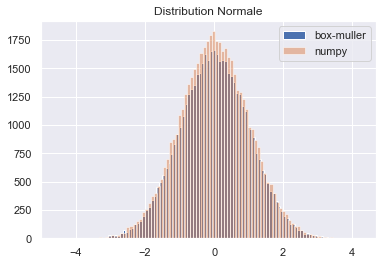

In [5]:
N = 1000
p = 50

Z = normale((N,p))

print(Z.shape)
plt.hist(Z.flatten(), bins=100, label='box-muller')
plt.hist(np.random.normal(size=(Z.size)), bins=100, alpha=0.5, label='numpy')
plt.legend()
plt.title('Distribution Normale')
plt.show()

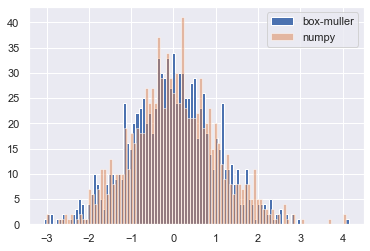

In [6]:
plt.hist(Z[:, 0], bins=100, label='box-muller')
plt.hist(np.random.normal(size=(N)), bins=100, alpha=0.5, label='numpy')
plt.legend()
plt.show()

# Simulation des trajectoires

Le modèle Cox-Ingersoll-Ross pour les intérêts est :
$$dS_t=a(b-S_t)dt+\sigma\sqrt{S_t}dW_t,$$
avec $a$ le paramètre controllant la vitesse de retour à la moyenne $b$. On va approximier la solution dans un premier temps avec la discétisation de Euler-Marayama en soustraillant les termes.
$$S_{t+1}-S_t=a(b-S_t)\Delta t + \sigma\sqrt{S_t}(W_{t+1}-W_t).$$
Cela signifi que notre trajectoire sera calculé par 
$$S_{t+1}=S_t+a(b-S_t)\Delta t + \sigma\sqrt{S_t \Delta t}Z,$$
Où $Z \sim N(0, 1)$ car $W_t$ est un mouvement brownien.

Plus de détail sur le modèle CIR: [Cox-Ingersoll-Ross](https://en.wikipedia.org/wiki/Cox–Ingersoll–Ross_model)

Plus de détail sur la méthode Euler-Maruyama: [Euler-Maruyama](https://en.wikipedia.org/wiki/Euler–Maruyama_method)

In [7]:
a = 0.2
b = 0
sigma = 0.3
T = 1
N = 20

s0 = 6

p = 10

Zp = normale((N,p))

K = 5
r = 0.05

In [8]:
def simple_iter(st, Z, dt):
    return st + a*(b-st)*dt + sigma*np.sqrt(st*dt)*Z

def St(Zp, iteration=simple_iter):
    N = len(Zp)
    p = len(Zp[0])
    dt = T/N

    traj = np.zeros((N+1,p))
    traj[0] = np.array([s0]*p)
    
    for i in range(N):
        traj[i+1] = iteration(traj[i], Zp[i], dt)   
  
    return traj

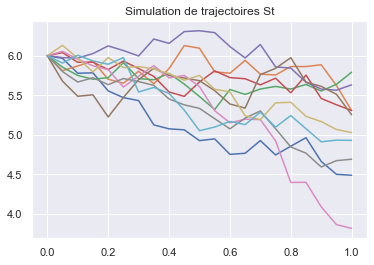

In [9]:
time_axis = np.linspace(0, T, N+1) # N+1 to account for r0

liste_St = St(Zp)

for i in range(min(p, 100)):
    plt.plot(time_axis.tolist(), liste_St[:, i])

plt.title('Simulation de trajectoires St')
plt.show()

# Calcul du prix

In [10]:
def Stk(St, k=20):
    N = St.shape[0] - 1
    liste_j = np.linspace(0, N, k+1, dtype = int)

    liste_Stk = []
    for i in range(k):
        x = np.array([liste_j[i], liste_j[i]+1])
        liste_Stk.append(interpolate.interp1d(x/N, St[x].transpose())(i/k))
  
    liste_Stk.append(St[-1])

    return np.array(liste_Stk[1:])

In [11]:
def phi(St):
    St = (St.mean(axis=0) - K)
    St[St < 0] = 0

    return np.exp(-r*T) * St

In [12]:
q = 1000
p = 100

Zpq = normale((q, N, p))

dist_C = np.array([phi(Stk(St(Zp))).mean() for Zp in Zpq])
dist_C_sym = np.array([np.concatenate((phi(Stk(St(Zp))), phi(Stk(St(-Zp))))).mean() for Zp in Zpq])

In [13]:
dist_C.mean()

0.41616149737533786

Var : 0.03373176819403141


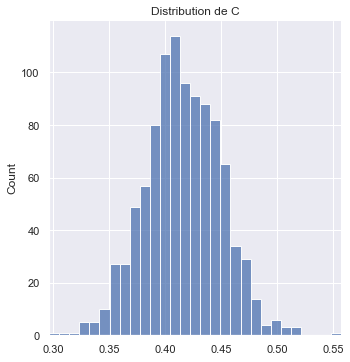

In [14]:
print('Var : ' + str(dist_C.std()))
plot_dist = sns.displot(data=dist_C)
plot_dist.set(xlim=(min(dist_C), max(dist_C)))
l = plt.title('Distribution de C')

Var : 0.007096490844207706


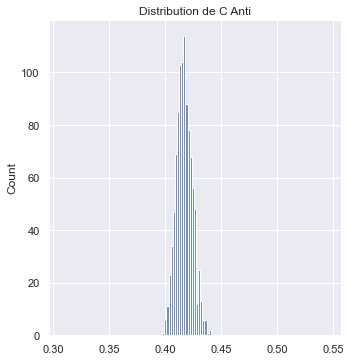

In [15]:
print('Var : ' + str(dist_C_sym.std()))
plot_dist_sym = sns.displot(data=dist_C_sym)
plot_dist_sym.set(xlim=(min(dist_C), max(dist_C)))
l = plt.title('Distribution de C Anti')

## Différentes manières de discrétiser le modèle CIR

### Balanced Implicit Scheme

$$S_{t+ \Delta t} = \frac{S_t(1 + C(S_t)) + \alpha(b - S_t) \Delta t + \sigma \sqrt{S_t \Delta t} Z }{1 + C(t, S_t))}$$

Avec 

$$ C(t, S_t) = \alpha \Delta t + \frac{\sigma \sqrt{\Delta t} |Z|}{\sqrt{S_t}}$$
Avec $Z$ qui suit une loi normale centrée réduite

In [16]:
def balanced_iter(st, Z, dt):
    C = a*dt + sigma*np.sqrt(dt)*np.abs(Z)/np.sqrt(st)
    return (st*(1+C) + a*(b-st)*dt + sigma*np.sqrt(st*dt)*Z)/(1 + C)

### Pathwise Adapted Linearization Quadratic

$$S_{t+ \Delta t} = S_t + (\alpha(\tilde{b} - S_t) + \sigma \beta \sqrt{S_t})(1 + \frac{\sigma \beta - 2 \alpha \sqrt{S_t}}{4 \sqrt{S_t}}\Delta t)\Delta t$$

Avec 

$$ \beta = \frac{Z}{\sqrt{\Delta t}}$$

et 

$$ \tilde{b} = b - \frac{\sigma^2}{4 \alpha}$$

Avec $Z$ qui suit une loi normale centrée réduite

In [17]:
def pathwise_iter(st, Z, dt):
    beta = Z / np.sqrt(dt)
    b_tilde = b - np.square(sigma)/(4*a)
  
    return st + (a*(b_tilde-st) + sigma*beta*np.sqrt(st))*(1 + ((sigma*beta - 2*a*np.sqrt(st))/(4*np.sqrt(st)))*dt)*dt

In [20]:
N = 5
T = 1

Zn = normale((N,p))

time_axis = np.linspace(0, T, N+1) # N+1 to account for r0

traj_simple = St(Zn, simple_iter)
traj_path = St(Zn, pathwise_iter)
traj_balance = St(Zn, balanced_iter)

100%|██████████| 10/10 [00:00<00:00, 411.17it/s]


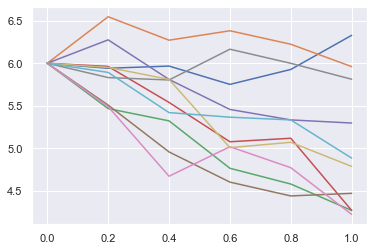

In [21]:
for i in tqdm(range(min(p, 10))):
    plt.plot(time_axis.tolist(), traj_simple[:, i])

plt.show()

100%|██████████| 10/10 [00:00<00:00, 427.50it/s]


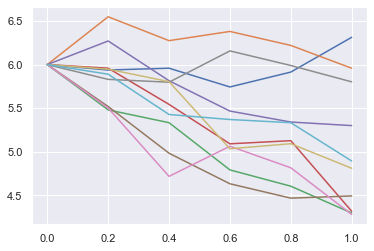

In [22]:
for i in tqdm(range(min(p, 10))):
    plt.plot(time_axis.tolist(), traj_path[:, i])

plt.show()

100%|██████████| 10/10 [00:00<00:00, 435.42it/s]


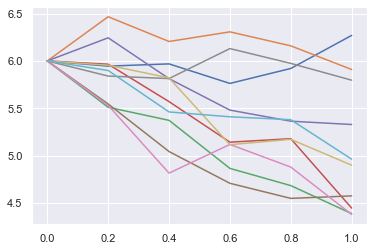

In [23]:
for i in tqdm(range(min(p, 10))):
    plt.plot(time_axis.tolist(), traj_balance[:, i])

plt.show()

100%|██████████| 10/10 [00:00<00:00, 256.66it/s]


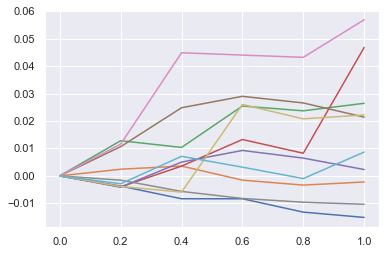

In [24]:
for i in tqdm(range(min(p, 10))):
    plt.plot(time_axis.tolist(), (traj_path - traj_simple)[:, i])

plt.show()

# Études des différents paramètres

In [25]:
def var_k(inter, p=20, q=20, N=1000, m=10):
    res = []
    for j in tqdm(range(m)):
        Zpq = np.random.normal(size=(q,N, p))
        for i in inter: 
            res.append({'var': np.std(np.array([phi(Stk(St(Zp), k = int(i))).mean() for Zp in Zpq])), 'k':int(i), 'type':'normal'})
            res.append({'var': np.std(np.array([np.concatenate((phi(Stk(St(Zp),k = int(i))), phi(Stk(St(-Zp), k = int(i))))).mean() for Zp in Zpq])), 'k':int(i), 'type':'anti'})
    return res

In [26]:
k_start = 10
k_end = 200 
nbr_points = 20
inter = np.linspace(k_start, k_end, nbr_points)

#df_res = pd.DataFrame(var_k(inter))
#df_res.to_csv('var_k.csv', index=False)

df_var = pd.read_csv('var_k.csv')
x = sns.lineplot(data=df_var, x='k', y='var', hue='type', hue_order=['normal', 'anti'])
l = plt.title('Effet de k sur la variance')

FileNotFoundError: [Errno 2] No such file or directory: 'var_k.csv'

In [75]:
def comp_time_N(inter, p=30, q=20, m=10):
    res = []
    for j in tqdm(range(m)): 
        for i in inter:
            Zpq = np.random.normal(size=(q, int(i), p))
            t1 = time.time()
            res_tmp = {'var': np.std(np.array([phi(Stk(St(Zp))).mean() for Zp in Zpq])), 'N':int(i), 'type':'normal'}
            t2 = time.time()
            res_anti_tmp = {'var': np.std(np.array([np.concatenate((phi(Stk(St(Zp))), phi(Stk(St(-Zp))))).mean() for Zp in Zpq])), 'N':int(i), 'type':'anti'}
            t3 = time.time()
            res_tmp['temps'] = t2-t1
            res_anti_tmp['temps'] = t3-t2
            
            res.append(res_tmp)
            res.append(res_anti_tmp)
            
    return res

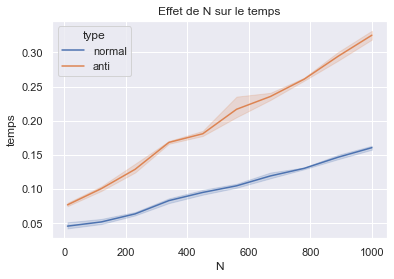

In [124]:
N_start = 1
N_end = 512
nbr_points = 10
inter = np.linspace(N_start, N_end, nbr_points)

#df_res = pd.DataFrame(comp_time_N(inter))
#df_res.to_csv('comp_time_N.csv', index=False)

df_var = pd.read_csv('comp_time_N.csv')
ax = sns.lineplot(data=df_var, x='N', y='temps', hue='type', hue_order=['normal', 'anti'])
l = plt.title('Effet de N sur le temps')

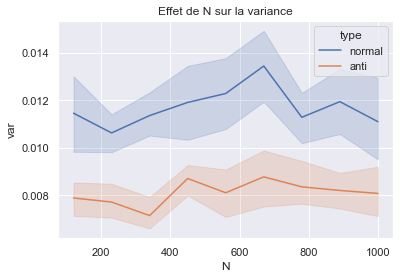

In [125]:
ax = sns.lineplot(data=df_var, x='N', y='var', hue='type', hue_order=['normal', 'anti'])
l = plt.title('Effet de N sur la variance')

In [78]:
def comp_time_p(inter, q=20, N=1000, m=10):
    res = []
    for j in tqdm(range(m)):
          for i in np.exp(inter):
                Zpq = np.random.normal(size=(q, N, int(i)))
            
                t1 = time.time()
                res_tmp = {'var': np.std(np.array([phi(Stk(St(Zp))).mean() for Zp in Zpq])), 'p':int(i), 'type':'normal'}
                t2 = time.time()
                res_anti_tmp = {'var': np.std(np.array([np.concatenate((phi(Stk(St(Zp))), phi(Stk(St(-Zp))))).mean() for Zp in Zpq])), 'p':int(i), 'type':'anti'}
                t3 = time.time()
                res_tmp['temps'] = t2-t1
                res_anti_tmp['temps'] = t3-t2
                
                res.append(res_tmp)
                res.append(res_anti_tmp)
    return res

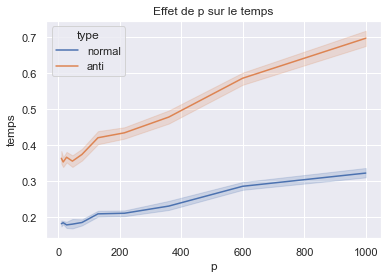

In [122]:
p_start = 10
p_end = 1000
nb_points = 10
inter = np.linspace(np.log(p_start), np.log(p_end), nbr_points)

#df_res = pd.DataFrame(comp_time_p(inter))
#df_res.to_csv('comp_time_p.csv', index=False)

df_var = pd.read_csv('comp_time_p.csv')
ax = sns.lineplot(data=df_var, x='p', y='temps', hue='type', hue_order=['normal', 'anti'])
l = plt.title('Effet de p sur le temps')

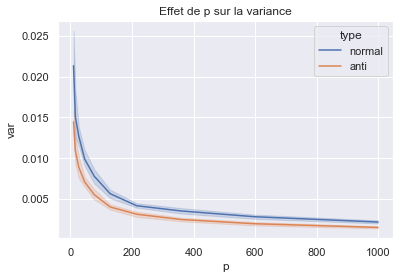

In [121]:
ax = sns.lineplot(data=df_var, x='p', y='var', hue='type', hue_order=['normal', 'anti'])
l = plt.title('Effet de p sur la variance')

# Multi-level Monte Carlo

In [27]:
def reduce(Zp, N, N_max):
    return np.add.reduceat(Zp, range(0, Zp.shape[0], N_max//N), axis=0)

In [28]:
def regression(N, x, y):
    csum = np.zeros(3)
    csum_y = np.zeros(2)

    for i in range(1, N):
        csum[0] += 1.0
        csum[1] += x[i]
        csum[2] += x[i]**2
        csum_y[0] += y[i]
        csum_y[1] += y[i]*x[i]

    a = (csum[0]*csum_y[1] - csum[1]*csum_y[0]) / (csum[0]*csum[2] - csum[1]*csum[1])
    b = (csum[2]*csum_y[0] - csum[1]*csum_y[1]) / (csum[0]*csum[2] - csum[1]*csum[1])
    return a, b

def mlmc(Lmin, Lmax, N0, eps, mlmc_l, gamma, **kwargs):

    # check input parameters
    assert Lmin >= 2, "error: need Lmin >= 2"
    assert Lmax >= Lmin, "error: need Lmax >= Lmin"
    assert N0 > 0, "error: need N0 > 0"
    assert eps > 0, "error: need eps > 0"
    assert gamma > 0, "error: need gamma > 0"   
    
    # initialization, use zero if alpha_0 and/or beta_0 not specified
    # if they are not specified, they will be estimated later
    if "alpha_0" in kwargs:
        alpha = max(0.0, kwargs["alpha_0"])
    else:
        alpha = 0 
    if "beta_0" in kwargs:
        beta = max(0.0, kwargs["beta_0"])
    else:
        beta = 0  
    
    theta = 0.25                              # MSE split between bias^2 and variance   
    L = Lmin;                                 # current level we are up to, starts at Lmin
    converged = False;  

    # initialize arrays
    Nl = [0 for i in range(Lmax + 1)] 
    Cl = np.array( [ 2.0 ** (l * gamma) for l in range(Lmax + 1) ] )
    suml = np.zeros( (4, Lmax + 1) )           # stores sums on various levels
    dNl = [0 for i in range(Lmax + 1)]         # number of additional samples to generate on level l
    ml = np.zeros(Lmax + 1)                    # absolute average
    Vl = np.zeros(Lmax + 1)                    # variance
    x = np.zeros(Lmax + 1)
    y = np.zeros(Lmax + 1)

    # initialize dNl (how many new samples we need on each level)
    for l in range(Lmin + 1):
        dNl[l] = N0

    # main loop

    while converged == False:
        # update sample sums
        # iterate over all the levels 
        for l in range(L+1):
            # if we need to generate additional samples on level l
            if dNl[l] > 0:
                # low-level function returns sum and sum of squares for 
                # dNl[l] samples on level l
                sums = mlmc_l( l, dNl[l] )
                suml[0][l] += dNl[l]            # number of samples on level l
                suml[1][l] += sums[0]           # sum of samples on level l
                suml[2][l] += sums[1]           # sum of squares of samples on level l

        # compute absolute average and variance, correct for possible under-sampling,
        # and set optimal number of new samples

        csum = 0.0                               # cumulative cost

        for l in range(L+1):
            # computes absolute average and variance
            # for number of samples on level 1, take max with 1 so sure we are not dividing by zero
            num_l = max(suml[0][l], 1)
            ml[l] = abs( suml[1][l] / num_l )
            Vl[l] = max( 0.0, suml[2][l]/num_l - ml[l]**2 )
            # correct for possible under-sampling in situations where there are few samples
            if l > 1:
                ml[l] = max( ml[l], 0.5 * ml[l-1] / ( 2.0 ** alpha) )
                Vl[l] = max( Vl[l], 0.5 * Vl[l-1] / ( 2.0 ** beta) )
            # cumulative sum of costs at each level
            csum += math.sqrt( Vl[l] * Cl[l] )

        # set optimal number of additional samples needed at each level
        # we make our estimate then subtract how many samples we currently
        # have at each level
        # for l in range(L+1):
        #     Ns = np.ceil( math.sqrt( Vl[l]/Cl[l] ) * csum / ( (1.0-theta)*(eps**2) ) )
        #     dNl[l] = int( max( 0, Ns - suml[0][l] ) )

        for l in range(L+1):
            Ns = max(0, math.sqrt( Vl[l]/Cl[l] ) * csum / ( (1.0-theta)*(eps**2) ) - suml[0][l] )
            dNl[l] = int( np.ceil( Ns ) )

        # use linear regression to estimate alpha, beta if not given

        if ("alpha_0" not in kwargs):
            for l in range(1, L + 1):
                x[l-1] = l;
                y[l-1] = -np.log2( ml[l] )
            alpha, sumsq = regression(L, x, y)

        if ("beta_0" not in kwargs):
            for l in range(1, L + 1):
                x[l-1] = l
                y[l-1] = -np.log2( Vl[l] )
            beta, sumsq = regression(L, x, y)

        # if (almost) converged, estimate remaining error and decide 
        # whether a new level is required

        csum = 0.0
        # checks to see if we need more than 1% more samples than we currently have
        for l in range(0, L+1):
            csum += max( 0.0, dNl[l] - 0.01*suml[0][l] )

        # if we don't, then either we are done, or we need a new level
        if csum == 0:
            converged = True;
            # check to see if we've actually converged
            rem = ml[L] / ( (2.0**alpha) - 1.0 )

            # if we haven't then add a new level, if allowed
            if rem > math.sqrt(theta)*eps:
                # if we are at the maximum level
                if L == Lmax:
                    print("*** failed to achieve weak convergence ***")
                else:
                    converged = False;
                    # otherwise go up to the next level and recompute how many new
                    # samples we need for each level
                    L += 1
                    csum = 0.0;
                    for l in range(0, L+1):
                        csum += math.sqrt( Vl[l]*Cl[l] )
                    for l in range(0, L+1):
                        Ns = max(0, math.sqrt( Vl[l]/Cl[l] ) * csum / ( (1.0-theta)*(eps**2) ) - suml[0][l] )
                        dNl[l] = int( np.ceil( Ns ) )

    # finally, evaluate multilevel estimator

    P = 0.0;
    for l in range(0, L+1):
        P += suml[1][l]/suml[0][l]
        Nl[l] = int(suml[0][l])

    return P, Nl

In [29]:
def mlmc_l(l,p):
    if l == 0:
        liste_Y, liste_Y2, liste_Y3, liste_Y4, liste_Y5, liste_Y6 = 0,0,0,0,0,0
    elif l == 1:
        Zpq = normale((l, p))
        liste_Stk =[Stk(np.nan_to_num(St(Zpq)))]

        liste_phi = np.array([phi(St) for St in liste_Stk])

        liste_Y= (liste_phi).sum()  
        liste_Y2 = np.square(liste_phi).sum()
        liste_Y3 = np.power(liste_phi,3).sum()
        liste_Y4 = np.power(liste_phi,4).sum()
        liste_Y5 = liste_phi.sum()
        liste_Y6 = np.square(liste_phi).sum()
    else:
        Zpq = normale((l, p))
        liste_Stk =[Stk(np.nan_to_num(St(Zpq)))]
        liste_Stk2 = [Stk(np.nan_to_num(St(reduce(Zpq, l//2, l))))]
        liste_phi = np.array([phi(St) for St in liste_Stk])
        liste_phi2 = np.array([phi(St) for St in liste_Stk2])
        liste_Y= (liste_phi-liste_phi2).sum()
        liste_Y2 = np.square(liste_phi-liste_phi2).sum()
        liste_Y3 = np.power(liste_phi-liste_phi2,3).sum()
        liste_Y4 = np.power(liste_phi-liste_phi2,4).sum()
        liste_Y5 = liste_phi.sum()
        liste_Y6 = np.square(liste_phi).sum()
        
    return np.array([liste_Y, liste_Y2, liste_Y3, liste_Y4, liste_Y5, liste_Y6])

<ipython-input-28-6994a92bf8ed>:12: RuntimeWarning: invalid value encountered in double_scalars
  a = (csum[0]*csum_y[1] - csum[1]*csum_y[0]) / (csum[0]*csum[2] - csum[1]*csum[1])
<ipython-input-28-6994a92bf8ed>:13: RuntimeWarning: invalid value encountered in double_scalars
  b = (csum[2]*csum_y[0] - csum[1]*csum_y[1]) / (csum[0]*csum[2] - csum[1]*csum[1])


0.038223417306790824
1.040705919265747


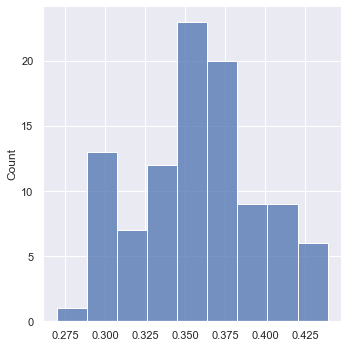

In [57]:
qmlmc = []
S0 = 6
t1=time.time()
for q in range(100):
    qmlmc.append(mlmc(2, 10, 100, 0.05, mlmc_l,np.log2(3))[0])
t2 = time.time() - t1
print(np.std(qmlmc))
print(t2)
plot_dist = sns.displot(data=qmlmc)

0.03567512256955529
1.1010620594024658


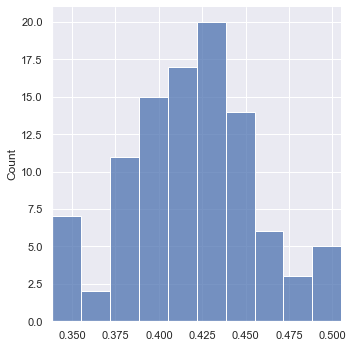

In [58]:
q = 100
p = 100
t1 = time.time()
Zpq = normale((q,N,p))
dist_C = np.array([phi(Stk(St(Zp))).mean() for Zp in Zpq])
dist_C_sym = np.array([np.concatenate((phi(Stk(St(Zp))), phi(Stk(St(-Zp))))).mean() for Zp in Zpq])
print(dist_C.std())
t2 = time.time() - t1 
print(t2)
plot_dist = sns.displot(data=dist_C)
plot_dist.set(xlim=(min(dist_C), max(dist_C)))

# Quasi Monte Carlo

In [32]:
def van_der_corput(n_sample, base=2):
    sequence = []
    
    for i in range(n_sample):
        n_th_number, denom = 0., 1.
        while i > 0:
            i, remainder = divmod(i, base)
            denom *= base
            n_th_number += remainder / denom
        sequence.append(n_th_number)

    return sequence

In [33]:
van_der_corput(10)

[0.0, 0.5, 0.25, 0.75, 0.125, 0.625, 0.375, 0.875, 0.0625, 0.5625]

In [34]:
def vdc_normale(shape):
    mat = np.zeros(shape)
    
    size1 = mat.size//2
    size2 = size1 if mat.size%2 else size1 + 1
    U = np.array(van_der_corput(size1+1) + van_der_corput(size2+2, 3)[2:])
    Z = box_muller(U[2:])
    
    return Z.reshape(shape)

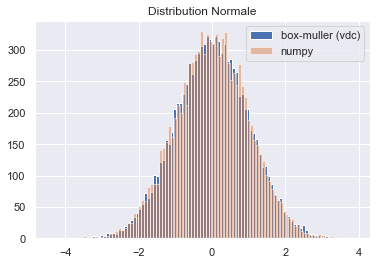

In [35]:
p = 1000
N = 10
Z = vdc_normale((N,p))

plt.hist(Z.flatten(), bins=100, label='box-muller (vdc)')
plt.hist(np.random.normal(size=(p*N)), bins=100, alpha=0.5, label='numpy')
plt.legend()
plt.title('Distribution Normale')
plt.show()

In [36]:
q = 1000
p = 100

Zpq = vdc_normale((q, N, p))

dist_C_vdc = np.array([phi(Stk(St(Zp))).mean() for Zp in Zpq])
dist_C_sym_vdc = np.array([np.concatenate((phi(Stk(St(Zp))), phi(Stk(St(-Zp))))).mean() for Zp in Zpq])

Var : 0.0032377311843468813


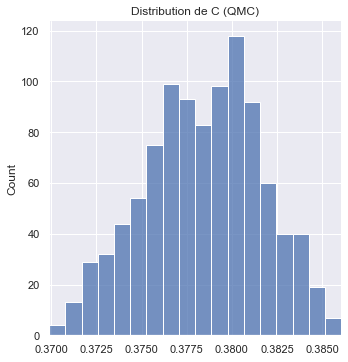

In [37]:
print('Var : ' + str(dist_C_vdc.std()))
plot_dist = sns.displot(data=dist_C_vdc)
ax = plot_dist.set(xlim=(min(dist_C_vdc), max(dist_C_vdc)))
plt.title('Distribution de C (QMC)')
plt.savefig('test.png')

Var : 0.0007202300364825076


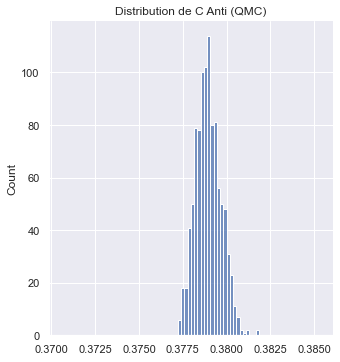

In [38]:
print("Var : " + str(dist_C_sym_vdc.std()))
plot_dist = sns.displot(data=dist_C_sym_vdc)
plt.title('Distribution de C Anti (QMC)')
ax = plot_dist.set(xlim=(min(dist_C_vdc), max(dist_C_vdc)))

In [ ]:
s